In [1]:
import pandas as pd
from pycaret.regression import *
from sklearn.model_selection import train_test_split
from pandas_profiling import ProfileReport
from IPython.display import display
from pycaret.utils.generic import check_metric
import os
import numpy as np

In [2]:
class PycaretRegressionPipeline:
    def __init__(self, data, target_column, experiment_name=None, session_id=None):
        self.data = data
        self.target_column = target_column
        self.experiment_name = experiment_name
        self.session_id = session_id
        self.setup_complete = False
        self.exp_setup = None  # Adicionado para guardar a configuração do PyCaret

    def load_data(self, file_path):
        self.data = pd.read_csv(file_path)

    def split_data(self, test_size=None, frac=None, random_state=None):
        if test_size is not None:
            train_data, validation_data = train_test_split(self.data, test_size=test_size, random_state=random_state)
        else:
            train_data = self.data.sample(frac=frac, random_state=random_state)
            validation_data = self.data.drop(train_data.index)
            train_data.reset_index(inplace=True, drop=True)
            validation_data.reset_index(inplace=True, drop=True)

        print(f'Dados de Treinamento: {train_data.shape}')
        print(f'Dados de Validação: {validation_data.shape}')
        return train_data, validation_data

    def setup_environment(self, **kwargs):
        if self.setup_complete:
            print("Configuração já concluída. Se desejar executar novamente, crie uma nova instância.")
            return

        self.exp_setup = setup(
            data=self.data,
            experiment_name=self.experiment_name,
            target=self.target_column,
            session_id=self.session_id,
            **kwargs
        )
        
        # Armazenar o DataFrame transformado
        self.transformed_data = get_config("X_train").copy()
        print("DataFrame Transformado:")
        print(self.transformed_data.head())

        self.setup_complete = True

    def get_transformed_data(self):
        """
        Obtém o DataFrame transformado após a configuração do ambiente no PyCaret.

        :return: DataFrame transformado ou None se a configuração não estiver completa.
        """
        if not self.setup_complete:
            print("Por favor, execute setup_environment antes de obter o DataFrame transformado.")
            return None

        try:
            transformed_data = get_config("X_train")
            
            # Adicione aqui as etapas de transformação necessárias, substituindo esta linha
            # por código que realiza as transformações desejadas nos dados.

            return transformed_data
        except Exception as e:
            print(f"Erro ao obter o DataFrame transformado: {str(e)}")
            return None

    def create_and_compare_models(self):
        if not self.setup_complete:
            print("Por favor, execute setup_environment antes de criar um modelo.")
            return None

        # Comparando modelos
        best_model = compare_models()
        
        # Obtendo as métricas de desempenho do melhor modelo
        metrics_df = get_metrics()

        # Exibindo o DataFrame retornado
        print("DataFrame de Métricas:")
        print(metrics_df)

        # Exibindo as colunas presentes no DataFrame
        print("Colunas presentes no DataFrame de Métricas:")
        print(metrics_df.columns)

        # Verificando se as métricas desejadas estão presentes no DataFrame
        if 'R2' in metrics_df.columns and 'MSE' in metrics_df.columns and 'RMSE' in metrics_df.columns:
            # Obtendo os valores das métricas
            r2_value = metrics_df[metrics_df['Metric'] == 'R2']['Value'].iloc[0]
            mse_value = metrics_df[metrics_df['Metric'] == 'MSE']['Value'].iloc[0]
            rmse_value = metrics_df[metrics_df['Metric'] == 'RMSE']['Value'].iloc[0]

            # Armazenando as métricas para referência futura
            self.r2_value = r2_value
            self.mse_value = mse_value
            self.rmse_value = rmse_value

            # Exibindo as métricas
            print(f"R² Value: {r2_value}")
            print(f"MSE Value: {mse_value}")
            print(f"RMSE Value: {rmse_value}")
            
        print(best_model)
        
        # Obtendo o dicionário de hiperparâmetros
        hyperparams = self.get_estimator_dict(best_model)

        # Exibindo os hiperparâmetros
        print("Hiperparâmetros do melhor modelo:")
        for key, value in hyperparams.items():
            print(f" - {key}: {value}")

        if not best_model:
            print("Nenhum modelo disponível para comparação. Verifique seus dados ou parâmetros de configuração.")
            return None

        # Obtendo o código do melhor modelo
        self.best_model_code = best_model.__class__.__name__
    

        # Criando um modelo específico usando a instância do melhor modelo
        specific_model = create_model(best_model)
        
        # Obtendo o dicionário de hiperparâmetros do modelo específico
        hyperparams_specific = self.get_estimator_dict(specific_model)

        # Exibindo os hiperparâmetros do modelo específico
        print("Hiperparâmetros do modelo específico:")
        for key, value in hyperparams_specific.items():
            print(f" - {key}: {value}")
        
        print(specific_model)
        return specific_model

    def get_estimator_dict(self, model):
        """
        Retorna um dicionário contendo os hiperparâmetros do modelo.

        Args:
            model: O modelo de regressão.

        Returns:
            Um dicionário contendo os nomes e valores dos hiperparâmetros.
        """
        hyperparams = {}
        for attr in dir(model):
            if not attr.startswith("_"):
                try:
                    value = getattr(model, attr)
                    if not callable(value):
                        hyperparams[attr] = value
                except:
                    pass
        return hyperparams

    def plot_model_performance(self, model, plot_type):
        if not self.setup_complete:
            print("Por favor, execute setup_environment antes de criar um modelo.")
            return

        plot_model(model, plot=plot_type)

    def evaluate_model(self, model, *args, **kwargs):
        if not self.setup_complete:
            print("Por favor, execute setup_environment antes de criar um modelo.")
            return

        evaluate_model(model, *args, **kwargs)
        
    def evaluate_metric(self, metric_name, predictions, target):
        """
        Avalia uma métrica específica para as previsões do modelo.

        Args:
            metric_name: O nome da métrica a ser avaliada (por exemplo, 'R2', 'MAE').
            predictions: As previsões do modelo.
            target: Os valores reais da variável alvo.

        Returns:
            O valor da métrica calculada.
        """
        if not self.setup_complete:
            print("Por favor, execute setup_environment antes de avaliar as métricas.")
            return

        return check_metric(predictions, target, metric_name)

    def make_predictions(self, model, data):
        return predict_model(model, data)

    def set_model_save_directory(self, directory):
        self.model_save_directory = directory

    def finalize_and_save_model(self, model, model_name='model'):
        final_model = finalize_model(model)
        print(final_model)

        if self.model_save_directory is not None:
            model_path = os.path.join(self.model_save_directory, f"{model_name}")
        else:
            model_path = f"{model_name}.pkl"

        save_model(final_model, model_path)


    def load_saved_model(self, model_name='model'):
        return load_model(model_name)


In [3]:
def aih_gausian(df, column_monotonic, column_ignorate):
    
    #df_new is dataframe normalized to calculate recomendation
    df_new = pd.DataFrame()
    
    #df_aux is dataframe to originals values of houses
    df_aux = pd.DataFrame()
    
    #filter columns
    columns_no_monotonic = df.drop(column_monotonic, axis=1)
    columns_no_monotonic = df.drop(column_ignorate, axis=1)
    
    #data nomalizeding
    if (len(column_monotonic) >= 1):
        for column in column_monotonic:
            #calculate preference local indice
            aux_calc = 1 / df[column]
            aux_sum = aux_calc.sum()
            aux_column = np.array(aux_calc / aux_sum)
            df_new[column] = aux_column
            df_aux[column] = df[column]
            
    for column in columns_no_monotonic.columns:
        aux_calc = np.array(df[column] / df[column].sum())
        df_new[column] = aux_calc
        df_aux[column] = df[column]
        
    for column in column_ignorate:
        df_new[column] = df[column]
        df_aux[column] = df[column]
      
    #aplicating transform
    
    #set city of index(solve quest - why good city for rend?)
    df_new = df_new.set_index('CITY_original')
    df_aux = df_aux.set_index('CITY_original')
    
    #mean of lines 1/n while n is criterius number
    mean_lines = 1/df_new.shape[0]

    #std(transpose matrix) of lines
    std_lines = df_new.std().T
    
    #calculate coefiente of relashph
    cof_rel =  std_lines / mean_lines

    #normalizeding this coeficiente of relationship
    new_cof_normalized = np.array(cof_rel / cof_rel.sum()).reshape(-1,1)
    
    # multiplicate dataframe normalized with coeficiente of relationship
    percentes_result = np.array(df_new.dot(new_cof_normalized))
    
    #add result in dataframe
    df_aux['percent_result'] = percentes_result * 100
    df_aux = df_aux.sort_values(by = "percent_result", ascending=False)

    return df_aux

In [4]:

# Exemplo de utilização
pipeline = PycaretRegressionPipeline(data=None, target_column='RENT_AMOUNT_(R$)', experiment_name="regression_experiment", session_id=123)

# Carregando os dados
pipeline.load_data("../data/transformed/houses_to_rent_v2_transformed.csv")

# Separando os dados
train_data, validation_data = pipeline.split_data(frac=0.80, random_state=786)

# # Por exemplo, use 90% para treinamento e 10% para validação
# train_data, validation_data = pipeline.split_data(test_size=0.9, random_state=786)

# # Ou use 80% para treinamento e 20% para validação
# train_data, validation_data = pipeline.split_data(test_size=0.8, random_state=786)


# Configurando o ambiente
pipeline.setup_environment(profile=True,
                           transform_target=True,
                           normalize=True,
                           low_variance_threshold=0.3,
                        #    bin_numeric_features=['ANIMAL', 'FURNITURE'],
                           n_jobs=-1,
                           use_gpu=True,
                           )

# Seus dados
# data_to_profile = pipeline.data

# # Criando o perfil
# profile = ProfileReport(data_to_profile, title='Pandas Profiling Report', explorative=True)

# # Exibindo no Jupyter Notebook
# display(profile.to_notebook_iframe())

Dados de Treinamento: (6370, 13)
Dados de Validação: (1593, 13)
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trai

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDAP=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDAP=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDAP=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDAP=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDAP=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDAP=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDAP=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDAP=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDAP=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDAP=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDAP=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDAP=1


,Description,Value
0,Session id,123
1,Target,RENT_AMOUNT_(R$)
2,Target type,Regression
3,Original data shape,"(7963, 13)"
4,Transformed data shape,"(7963, 10)"
5,Transformed train set shape,"(5574, 10)"
6,Transformed test set shape,"(2389, 10)"
7,Numeric features,11
8,Categorical features,1
9,Preprocess,True


Loading profile... Please Wait!
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bi

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDAP=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDAP=1


In [5]:
# Exemplo de utilização
pipeline = PycaretRegressionPipeline(data=None, target_column='RENT_AMOUNT_(R$)', experiment_name="regression_experiment", session_id=123)

# Carregando os dados
pipeline.load_data("../data/transformed/houses_to_rent_v2_transformed.csv")

# Separando os dados
train_data, validation_data = pipeline.split_data(frac=0.80, random_state=786)

# # Por exemplo, use 90% para treinamento e 10% para validação
# train_data, validation_data = pipeline.split_data(test_size=0.9, random_state=786)

# # Ou use 80% para treinamento e 20% para validação
# train_data, validation_data = pipeline.split_data(test_size=0.8, random_state=786)


# Configurando o ambiente
pipeline.setup_environment(profile=False,
                           transform_target=True,
                           normalize=True,
                           low_variance_threshold=0.3,
                        #    bin_numeric_features=['ANIMAL'],
                           n_jobs=-1,
                           use_gpu=True,
                           )

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDAP=1


Dados de Treinamento: (6370, 13)
Dados de Validação: (1593, 13)
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trai

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDAP=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDAP=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDAP=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.


[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDAP=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDAP=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDAP=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.


[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDAP=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDAP=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDAP=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.


[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDAP=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDAP=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.


,Description,Value
0,Session id,123
1,Target,RENT_AMOUNT_(R$)
2,Target type,Regression
3,Original data shape,"(7963, 13)"
4,Transformed data shape,"(7963, 10)"
5,Transformed train set shape,"(5574, 10)"
6,Transformed test set shape,"(2389, 10)"
7,Numeric features,11
8,Categorical features,1
9,Preprocess,True


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDAP=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDAP=1


In [6]:
# Obtendo o DataFrame transformado
df_transformed = pipeline.get_transformed_data()

In [7]:
df_transformed.head()

,CITY,AREA,ROOMS,BATHROOM,PARKING_SPACES,FLOOR,ANIMAL,FURNITURE,HOA_(R$),PROPERTY_TAX_(R$),FIRE_INSURANCE_(R$),TOTAL_(R$)
2167,Rio de Janeiro,140,3,2,2,4.0,1,0,1450,169,35,4354
5519,Porto Alegre,160,2,4,2,8.0,0,1,950,200,46,4296
2571,Rio de Janeiro,100,3,1,0,12.0,1,0,1367,217,44,5027
5341,São Paulo,115,2,2,1,18.0,1,1,950,125,83,7658
5893,São Paulo,188,3,4,3,1.0,1,0,2800,750,61,8411


In [8]:
# Comparando e criando modelos
best_model = pipeline.create_and_compare_models()


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,75.9255,47399.8096,206.9932,0.9952,0.0472,0.0242,0.1100
et,Extra Trees Regressor,75.1953,55399.0930,227.2705,0.9944,0.0608,0.0264,0.1670
rf,Random Forest Regressor,74.2656,57768.1723,232.8095,0.9941,0.0601,0.0255,0.2390
gbr,Gradient Boosting Regressor,97.6782,63053.5329,243.4731,0.9936,0.0625,0.0324,0.5350
dt,Decision Tree Regressor,85.6432,94515.1374,300.8300,0.9902,0.0802,0.0308,0.0700
knn,K Neighbors Regressor,311.5926,285049.7241,531.5029,0.9709,0.1549,0.0997,0.0670
ada,AdaBoost Regressor,364.0393,454837.9983,666.2064,0.9549,0.1208,0.0924,0.2550
llar,Lasso Least Angle Regression,2101.1073,11096972.2048,3325.1711,-0.1188,0.7621,0.6622,0.0520
en,Elastic Net,2101.1073,11096972.2048,3325.1711,-0.1188,0.7621,0.6622,0.0650
lasso,Lasso Regression,2101.1073,11096972.2048,3325.1711,-0.1188,0.7621,0.6622,0.0660


DataFrame de Métricas:
        Name Display Name                                     Score Function  \
ID                                                                             
mae      MAE          MAE   <function mean_absolute_error at 0x7f008358bd90>   
mse      MSE          MSE    <function mean_squared_error at 0x7f00835b4160>   
rmse    RMSE         RMSE    <function mean_squared_error at 0x7f00835b4160>   
r2        R2           R2              <function r2_score at 0x7f00835b4670>   
rmsle  RMSLE        RMSLE  <function RMSLEMetricContainer.__init__.<local...   
mape    MAPE         MAPE  <function MAPEMetricContainer.__init__.<locals...   

                                                  Scorer Target  \
ID                                                                
mae                              neg_mean_absolute_error   pred   
mse                               neg_mean_squared_error   pred   
rmse                         neg_root_mean_squared_error   pred   
r

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,68.6958,14869.6598,121.9412,0.9985,0.0347,0.0229
1,83.8655,73559.6303,271.2188,0.9929,0.0421,0.0239
2,72.0359,25543.1733,159.8223,0.9978,0.0495,0.0239
3,76.1682,38524.8229,196.2774,0.9961,0.0530,0.0264
4,86.8555,94969.4638,308.1712,0.9897,0.0507,0.0262
5,65.5683,15716.8113,125.3667,0.9981,0.0458,0.0236
6,81.2999,82724.1060,287.6180,0.9915,0.0574,0.0232
7,70.9576,39723.8483,199.3084,0.9966,0.0415,0.0223
8,64.5635,18427.3465,135.7474,0.9979,0.0452,0.0234


Hiperparâmetros do modelo específico:
 - best_iteration_: 0
 - best_score_: defaultdict(<class 'collections.OrderedDict'>, {})
 - booster_: <lightgbm.basic.Booster object at 0x7f0078190790>
 - boosting_type: gbdt
 - class_weight: None
 - colsample_bytree: 1.0
 - evals_result_: {}
 - feature_importances_: [ 147   26   14   18   63  595  283 1054  800]
 - feature_name_: ['AREA', 'ROOMS', 'BATHROOM', 'PARKING_SPACES', 'FLOOR', 'HOA_(R$)', 'PROPERTY_TAX_(R$)', 'FIRE_INSURANCE_(R$)', 'TOTAL_(R$)']
 - fitted_: True
 - importance_type: split
 - learning_rate: 0.1
 - max_depth: -1
 - min_child_samples: 20
 - min_child_weight: 0.001
 - min_split_gain: 0.0
 - n_estimators: 100
 - n_estimators_: 100
 - n_features_: 9
 - n_features_in_: 9
 - n_iter_: 100
 - n_jobs: -1
 - num_leaves: 31
 - objective: None
 - objective_: regression
 - random_state: 123
 - reg_alpha: 0.0
 - reg_lambda: 0.0
 - subsample: 1.0
 - subsample_for_bin: 200000
 - subsample_freq: 0
LGBMRegressor(n_jobs=-1, random_state=123)


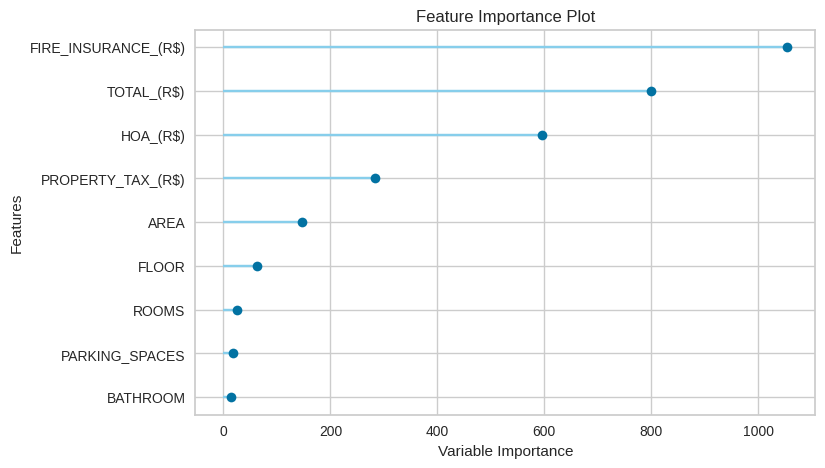

In [9]:
# Exemplo: Visualização de importância de características
pipeline.plot_model_performance(best_model, plot_type='feature')


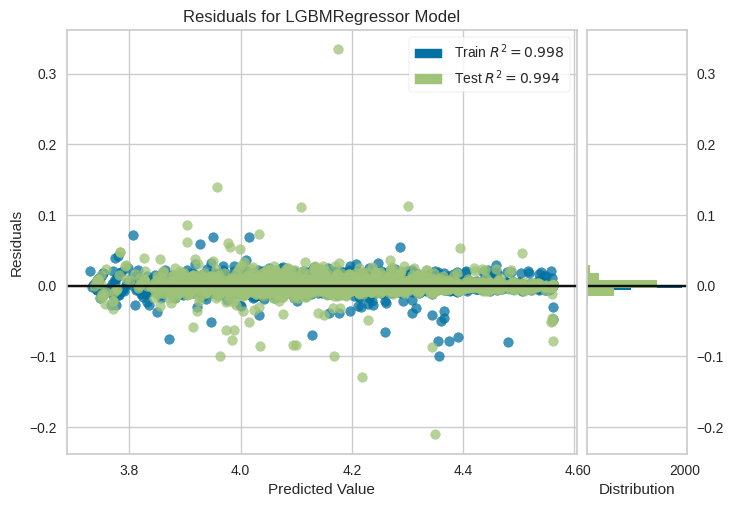

In [10]:
# Exibindo gráfico de desempenho do modelo
pipeline.plot_model_performance(best_model, plot_type='residuals')

In [11]:
# Ajuste automático de hiperparâmetros
# tuned_model = tune_model(best_model)


In [12]:
# Avaliação usando validação cruzada
pipeline.evaluate_model(best_model,  fold = 10)


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [13]:
# Exportar modelo treinado
# pipeline.finalize_and_save_model(best_model, model_name='best_regression_model')


In [14]:
# Avaliando o modelo
pipeline.evaluate_model(best_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [15]:
# Fazendo previsões
predictions = pipeline.make_predictions(best_model, data=validation_data)
predictions.head()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,64.4656,35430.5088,188.2299,0.9966,0.0357,0.0199


,CITY,AREA,ROOMS,BATHROOM,PARKING_SPACES,FLOOR,ANIMAL,FURNITURE,HOA_(R$),PROPERTY_TAX_(R$),FIRE_INSURANCE_(R$),TOTAL_(R$),RENT_AMOUNT_(R$),prediction_label
0,São Paulo,25,1,1,0,1.0,0,0,0,25,11,836,800,817.489270
1,Rio de Janeiro,72,2,1,0,7.0,1,0,740,85,25,2750,1900,1883.329583
2,São Paulo,152,2,2,1,3.0,1,1,1000,250,191,16440,15000,14890.291816
3,Rio de Janeiro,35,1,1,0,2.0,1,1,590,35,30,2955,2300,2306.899615
4,São Paulo,36,1,1,0,11.0,1,0,359,70,27,2556,2100,2075.177347


In [16]:
pipeline.evaluate_metric("R2", predictions["RENT_AMOUNT_(R$)"], predictions["prediction_label"])

0.9966

In [17]:
# Finalizando e salvando o modelo
pipeline.set_model_save_directory("../models/")
pipeline.finalize_and_save_model(best_model, model_name='pycaret_model_predicted')

Pipeline(memory=Memory(location=None),
         steps=[('target_transformation',
                 TransformerWrapperWithInverse(transformer=TargetTransformer(estimator=PowerTransformer(standardize=False)))),
                ('numerical_imputer',
                 TransformerWrapper(include=['AREA', 'ROOMS', 'BATHROOM',
                                             'PARKING_SPACES', 'FLOOR',
                                             'ANIMAL', 'FURNITURE', 'HOA_(R$)',
                                             'PROPERTY_TAX_(R$)',
                                             'FIRE_INSURANCE_(R$...
                                    transformer=OneHotEncoder(cols=['CITY'],
                                                              handle_missing='return_nan',
                                                              use_cat_names=True))),
                ('low_variance',
                 TransformerWrapper(exclude=[],
                                    transformer=VarianceThre

In [18]:
%cd "../models/"
%ls -lh

/home/calendario2009/Documents/desafio-eng-de-dados-prouni/dados-volkswagen/models
total 1,4M
-rw-rw-r-- 1 calendario2009 calendario2009 1,1M dez 16 23:04 logs.log
-rw-rw-r-- 1 calendario2009 calendario2009 309K dez 16 23:23 pycaret_model_predicted.pkl


In [19]:
# Obter previsões dos modelos
predictions = pipeline.make_predictions(best_model, data=validation_data)

# Criar DataFrame com previsões e valor total
df_predictions = validation_data.join(predictions, lsuffix="_original", rsuffix="_predicted")

df_predictions["total_predicted"] = predictions["prediction_label"]

# df_predictions.head(30)
# df_predictions.info()

# Exemplo selecionando colunas específicas
df_ahp_input_1 = df_predictions[["CITY_original", "TOTAL_(R$)_original", "AREA_original", "ROOMS_original"]]

# # Chamada do aih_gausian
df_recommendations = aih_gausian(df_ahp_input_1, column_monotonic=["TOTAL_(R$)_original"], column_ignorate=["CITY_original"])

# # Exibir recomendações principais
df_recommendations.head()


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,64.4656,35430.5088,188.2299,0.9966,0.0357,0.0199


,TOTAL_(R$)_original,AREA_original,ROOMS_original,percent_result
CITY_original,,,,
Belo Horizonte,10220,46335,4,14.486554
São Paulo,18320,24606,5,7.712093
Campinas,2417,12732,3,3.982431
São Paulo,26090,1000,4,0.348698
Rio de Janeiro,14700,950,6,0.321656


In [20]:
import matplotlib.pyplot as plt

# Obter previsões dos modelos
predictions = pipeline.make_predictions(best_model, data=validation_data)

# Criar DataFrame com previsões e valor total
df_predictions = validation_data.join(predictions, lsuffix="_original", rsuffix="_predicted")

df_predictions["total_predicted"] = predictions["prediction_label"]

# df_predictions.head(30)
# df_predictions.info()

# Exemplo selecionando colunas específicas
df_ahp_input_2 = df_predictions[["CITY_original", "TOTAL_(R$)_original", "AREA_original", "ROOMS_original", "RENT_AMOUNT_(R$)_predicted"]]

# Criar coluna com custo total estimado
df_ahp_input_2["TOTAL_estimated"] = df_ahp_input_2["TOTAL_(R$)_original"] - df_ahp_input_2["RENT_AMOUNT_(R$)_predicted"]

# Chamada do aih_gausian
df_recommendations = aih_gausian(df_ahp_input_2, column_monotonic=["TOTAL_estimated"], column_ignorate=["CITY_original"])

# Ordenar o DataFrame pela coluna percent_result
df_recommendations = df_recommendations.sort_values("percent_result", ascending=False)

# Exibir recomendações principais
df_recommendations.head()


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,64.4656,35430.5088,188.2299,0.9966,0.0357,0.0199


,TOTAL_estimated,TOTAL_(R$)_original,AREA_original,ROOMS_original,RENT_AMOUNT_(R$)_predicted,percent_result
CITY_original,,,,,,
Belo Horizonte,1720,10220,46335,4,8500,11.345631
São Paulo,10220,18320,24606,5,8100,6.096164
Campinas,817,2417,12732,3,1600,3.119959
Rio de Janeiro,91110,95610,35,1,4500,0.611862
São Paulo,11090,26090,1000,4,15000,0.353090


In [21]:
# Abordagem 1
df_recommendations_1 = aih_gausian(df_ahp_input_1, column_monotonic=["TOTAL_(R$)_original"], column_ignorate=["CITY_original"])
df_recommendations_1.head(10)


,TOTAL_(R$)_original,AREA_original,ROOMS_original,percent_result
CITY_original,,,,
Belo Horizonte,10220,46335,4,14.486554
São Paulo,18320,24606,5,7.712093
Campinas,2417,12732,3,3.982431
São Paulo,26090,1000,4,0.348698
Rio de Janeiro,14700,950,6,0.321656
São Paulo,20930,900,4,0.311212
São Paulo,11860,717,5,0.244257
São Paulo,26800,660,4,0.243385
São Paulo,27290,580,5,0.220191


In [22]:
# Abordagem 2
df_recommendations_2 = aih_gausian(df_ahp_input_2, column_monotonic=["TOTAL_estimated"], column_ignorate=["CITY_original"])
df_recommendations_2.head(10)


,TOTAL_estimated,TOTAL_(R$)_original,AREA_original,ROOMS_original,RENT_AMOUNT_(R$)_predicted,percent_result
CITY_original,,,,,,
Belo Horizonte,1720,10220,46335,4,8500,11.345631
São Paulo,10220,18320,24606,5,8100,6.096164
Campinas,817,2417,12732,3,1600,3.119959
Rio de Janeiro,91110,95610,35,1,4500,0.611862
São Paulo,11090,26090,1000,4,15000,0.353090
São Paulo,5930,20930,900,4,15000,0.295123
Rio de Janeiro,1700,14700,950,6,13000,0.277276
São Paulo,12290,27290,580,5,15000,0.259290
São Paulo,6800,26800,660,4,20000,0.253225


In [23]:
# Abordagem 1
df_recommendations_1["percent_result"].mean()


0.06277463904582549

In [24]:
# Abordagem 2
df_recommendations_2["percent_result"].mean()

0.06277463904582549

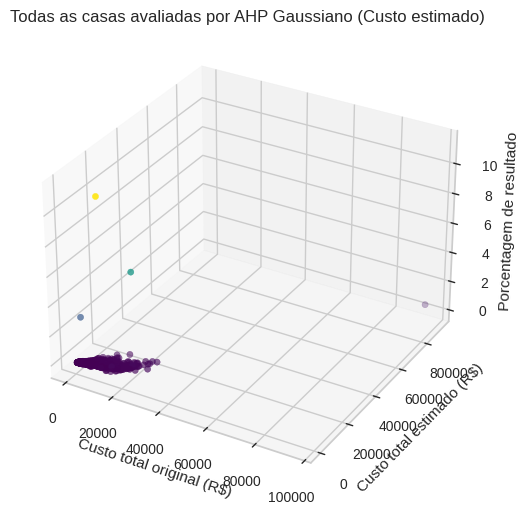

In [25]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df_recommendations["TOTAL_(R$)_original"], df_recommendations["TOTAL_estimated"], df_recommendations["percent_result"], c=df_recommendations["percent_result"], cmap="viridis")
ax.set_xlabel("Custo total original (R$)")
ax.set_ylabel("Custo total estimado (R$)")
ax.set_zlabel("Porcentagem de resultado")
ax.set_title("Todas as casas avaliadas por AHP Gaussiano (Custo estimado)")

plt.show()

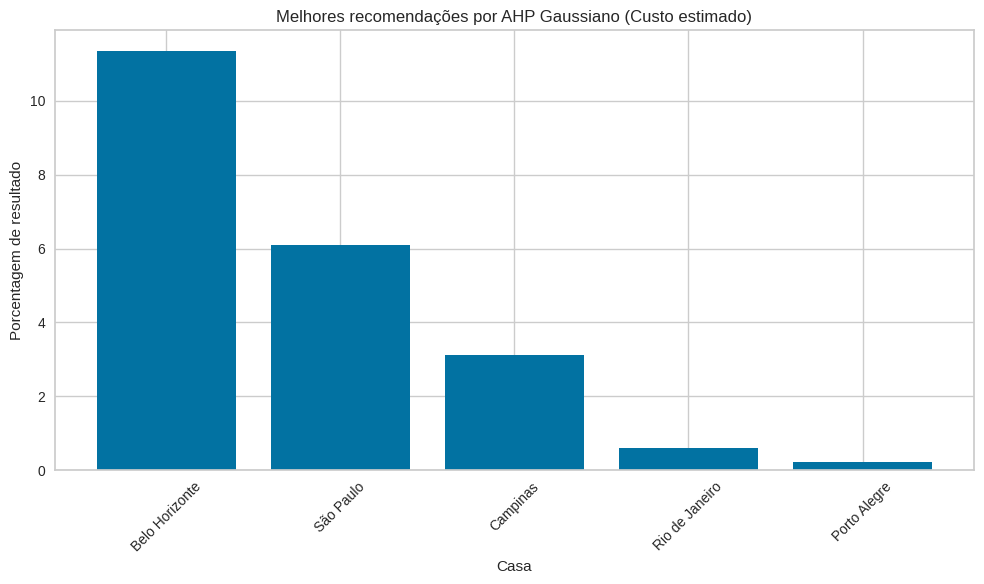

In [26]:
plt.figure(figsize=(10, 6))
plt.bar(df_recommendations.index, df_recommendations["percent_result"])
plt.xlabel("Casa")
plt.ylabel("Porcentagem de resultado")
plt.title("Melhores recomendações por AHP Gaussiano (Custo estimado)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


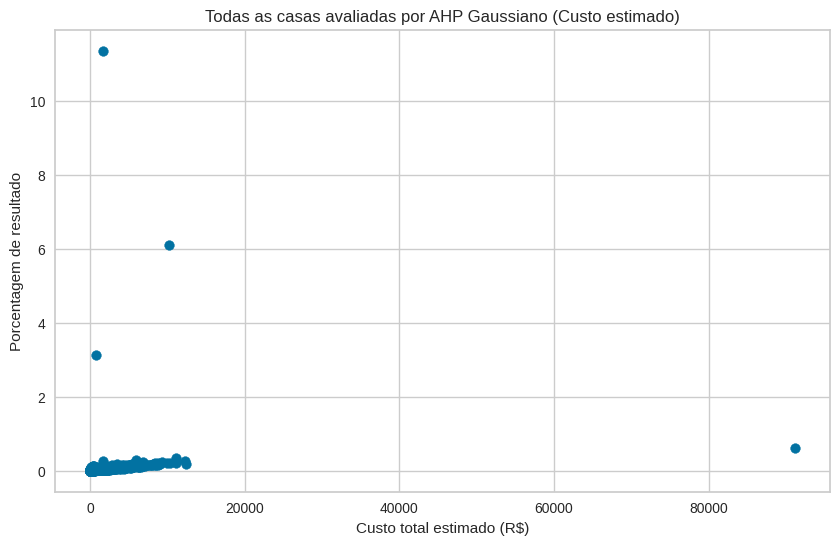

In [27]:
plt.figure(figsize=(10, 6))
plt.scatter(df_recommendations["TOTAL_estimated"], df_recommendations["percent_result"])
plt.xlabel("Custo total estimado (R$)")
plt.ylabel("Porcentagem de resultado")
plt.title("Todas as casas avaliadas por AHP Gaussiano (Custo estimado)")
plt.grid(True)
plt.show()
